# RQ 2 (Size)

> What is the size of unsafe blocks that programmers write?

## Setup

In [2]:
# import libraries
import itertools
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

import utils
import top_crates
from whitelists import *
from drawing import *

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15/1.5, 8/1.4]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)
# Font for paper
plt.rc('font', family='serif')

In [3]:
# Load tables
unsafe_blocks = utils.load_unsafe_thir_blocks()
unsafe_block_sizes = utils.load_unsafe_thir_block_sizes()

# Preprocessing
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"].copy()

## Query 3

> how many MIR statements does the compiler generate for user-written unsafe blocks

#### Results from the paper for comparison (Fig. 3)

![Fig. 3](pics/unsafe_blocks_size_cumulative.png)

In [4]:
# Count MIR elements
sizes_df = user_written_unsafe_blocks[['block']].join(
    unsafe_block_sizes[['block', 'statement_count', 'call_expr_count', 'has_trailing_expr']].set_index('block'),
    on='block',
    how='left',
)
user_written_unsafe_blocks["statement_count"] = sizes_df.statement_count
user_written_unsafe_blocks["call_expr_count"] = sizes_df.call_expr_count
user_written_unsafe_blocks["has_trailing_expr"] = sizes_df.has_trailing_expr
user_written_unsafe_blocks["statement_count_incl_trailing"] = sizes_df.statement_count + sizes_df.has_trailing_expr
user_written_unsafe_blocks[["block", "statement_count", "call_expr_count", "has_trailing_expr", "statement_count_incl_trailing"]]

,block,statement_count,call_expr_count,has_trailing_expr,statement_count_incl_trailing
0,13,2,5,True,3
1,22,0,4,True,1
2,52,0,1,True,1
3,44,0,1,True,1
4,68,0,1,True,1
5,59,0,1,True,1
6,65,0,1,True,1
7,71,0,2,True,1
8,88,0,1,True,1
9,92,0,1,True,1


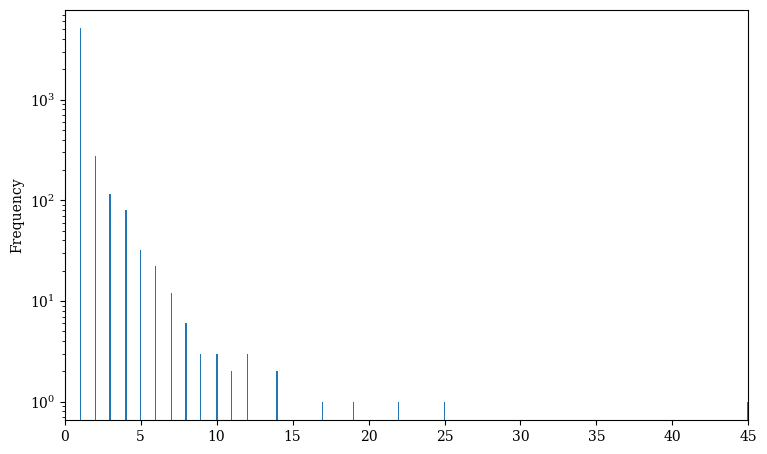

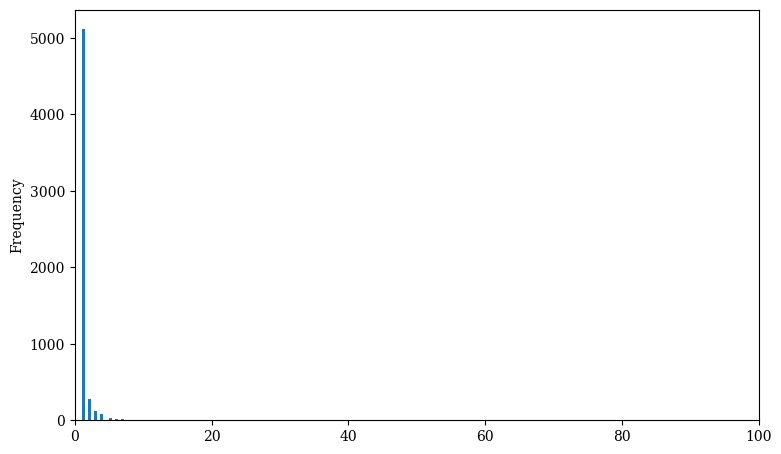

/tmp/ipykernel_1046/1933540958.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


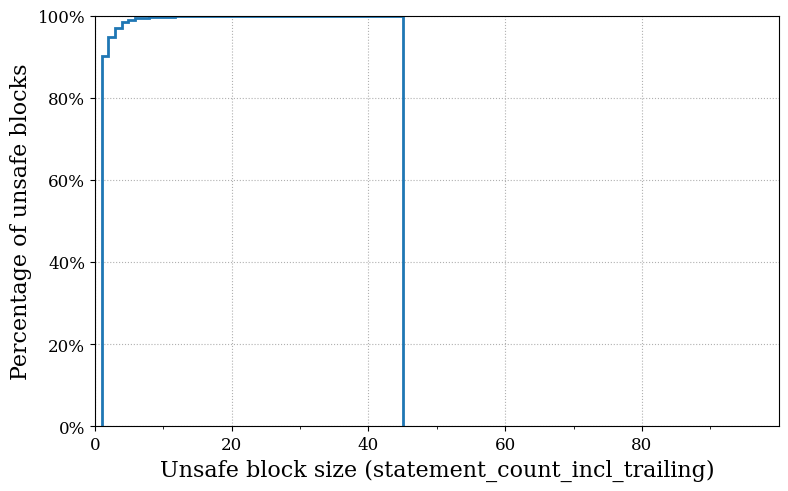

The portion of unsafe blocks covered in the depicted graph: 100.0 %
The portion of unsafe blocks with #21 MIR or less: 99.947127247092 %
Mean size of a unsafe block: 1.2379273880860064
Median size of a unsafe block: 1.0


In [16]:
# Plot histograms

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15/1.7, 8/1.5]

# Niels: pick either 'statement_count' or 'statement_count_incl_trailing'
col = 'statement_count_incl_trailing'

user_written_unsafe_blocks[col].plot.hist(
    bins=500,
    log=True,
    xlim=(0, user_written_unsafe_blocks[col].max())
)
plt.show()

user_written_unsafe_blocks[col].describe()

user_written_unsafe_blocks[
    user_written_unsafe_blocks[col] <= 100
][col].plot.hist(
    bins=100,
    xlim=(0, 100)
)
plt.show()

ax = user_written_unsafe_blocks[col].plot.hist(
    cumulative=True,
    density=1,
    bins=int(user_written_unsafe_blocks[col].max()),
    xlim=(0, 100),
    ylim=(0, 1),
    histtype="step",
    linewidth=2,
    fontsize=12,
    # title="Cumulative distribution",
)
ax.title.set_size(20)
ax.set_xlabel(f"Unsafe block size ({col})", fontsize=16)
ax.set_ylabel("Percentage of unsafe blocks", fontsize=16)
ax.set_axisbelow(True)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_xticks(range(0, 100, 10), minor=True)
ax.set_xticks(range(0, 100, 20))
ax.grid(True, linestyle='dotted')
plt.show()
print("The portion of unsafe blocks covered in the depicted graph:",
    100 * len(user_written_unsafe_blocks.query(f"{col} <= 100"))
    /len(user_written_unsafe_blocks), "%"
)
print("The portion of unsafe blocks with #21 MIR or less:",
    100 * len(user_written_unsafe_blocks.query(f"{col} <= 21"))
    /len(user_written_unsafe_blocks), "%"
)
print("Mean size of a unsafe block:", user_written_unsafe_blocks[col].mean())
print("Median size of a unsafe block:", user_written_unsafe_blocks[col].median())

## Follow-ups

> there is a significant share, namely 14.4% of tiny unsafe blocks that either wrap an expression (without function calls) or call a single unsafe function without changing any of its arguments

In [6]:
# Niels: old: of the user-written unsafe blocks just call an unsafe functions, whithout evaluationg expressions for the arguments
count_no_statements_only_trailing_calls = len(user_written_unsafe_blocks.query('statement_count == 0 and has_trailing_expr == True and call_expr_count > 0'))
print("{:.1%} of the user-written unsafe blocks are just a call with no associated statements".format(
    count_no_statements_only_trailing_calls / len(user_written_unsafe_blocks)
))
# Niels: old: of the user-written unsafe blocks just evaluates an expression, whithout calling any function
count_no_calls = sum(user_written_unsafe_blocks.call_expr_count == 0)
print("{:.1%} of the user-written unsafe blocks don't call any function".format(
    count_no_calls / len(user_written_unsafe_blocks)
))
print("sum: {:.1%}".format(
    (count_no_statements_only_trailing_calls + count_no_calls) / len(user_written_unsafe_blocks)
))

79.0% of the user-written unsafe blocks are just a call with no associated statements
5.9% of the user-written unsafe blocks don't call any function
sum: 84.9%


> Conversely, there is a small number (78 or 0.02%) of huge outliers whose size ranges from 2000 to 21306 #MIR.

Note: 0.02% of unsafe blocks corresponds to 78 of which
- 28 are generated by macros, 
- 16 are generated at compile time, and
- 34 appear to be user written.

In [7]:
# Niels: TODO: probably adjust the 2000 to something smaller? see based on 'Largest' output below.
large_blocks = user_written_unsafe_blocks.query("statement_count_incl_trailing >= 2000")
print("Count of huge outliers:", len(large_blocks))
print("Percentage:", 100*len(large_blocks)/len(user_written_unsafe_blocks))
print("Largest:", user_written_unsafe_blocks.statement_count_incl_trailing.max())

Count of huge outliers: 0
Percentage: 0.0
Largest: 45


In [8]:
data = user_written_unsafe_blocks[
    (user_written_unsafe_blocks.statement_count >= 2000)
    & (user_written_unsafe_blocks.expansion_kind != "Root")
]
print("gen by macros:", len(data))
print(data.crate.value_counts())
del data

gen by macros: 0
Series([], Name: count, dtype: int64)


In [9]:
data = user_written_unsafe_blocks[
    (user_written_unsafe_blocks.statement_count_incl_trailing >= 2000)
    & (user_written_unsafe_blocks.expansion_kind == "Root")
    & (user_written_unsafe_blocks.file_name.str.contains("out/"))
]
print("gen at compile time:", len(data))
print(data.crate.value_counts())
del data

gen at compile time: 0
Series([], Name: count, dtype: int64)


In [10]:
data = user_written_unsafe_blocks[
    (user_written_unsafe_blocks.statement_count_incl_trailing >= 2000)
    & (user_written_unsafe_blocks.expansion_kind == "Root")
    & (~user_written_unsafe_blocks.file_name.str.contains("out/"))
]
print("not gen at compile time or by macros:", len(data))
print(data.crate.value_counts())
print("top cases:")
data[
    data.statement_count_incl_trailing >= 12000
]

not gen at compile time or by macros: 0
Series([], Name: count, dtype: int64)
top cases:


,build,crate,crate_hash,def_path,def_path_hash,summary_key,block,check_mode,span,expansion_kind,expansion_kind_descr,file_name,line,col,statement_count,call_expr_count,has_trailing_expr,statement_count_incl_trailing
